# **호가창 및 체결 데이터 전처리**
전체 기간: 2024.09.23 ~ 2024.11.11 (총 50일)
- 1. 호가창과 체결 데이터 결합
- 2. 데이터 정제
- 3. 5호가만 선택
- 4. 파생변수 생성
- 5. 최종 변수 선택
- 6. 종속변수(=target) y 생성

# (1) 라이브러리 import

In [1]:
import glob
import os #작업 디렉토리 설정에 사용
import json #파일 불러오기에 사용
import re #파일 경로에서 날짜 정보만 추출할 때 사용
import time #총 실행시간 확인용
from tqdm import tqdm #진행률 표시

#넘파이 판다스 라이브러리
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

#시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt

# (2) 전처리1: 호가창과 체결 데이터 결합

## (2-1) 사용자 지정 함수 생성

In [16]:
### [함수 1] 데이터 불러오기
def load_json_to_dataframe(file_path):
  #JSON 데이터를 담을 리스트 초기화
  data_list = []

  #파일을 한 줄씩 읽고 JSON 객체로 변환하여 리스트에 추가
  with open(file_path, 'r') as f:
      for line in f:
          try:
              #JSON 객체로 변환 (단일 따옴표를 이중 따옴표로 변경)
              data = json.loads(line.strip().replace("'", '"'))
              data_list.append(data)
          except json.JSONDecodeError as e: #오류발생 시 메세지 출력
              print(f"Error decoding JSON in file {file_path}: {e}")

  #JSON 데이터를 데이터프레임으로 변환
  df = pd.DataFrame(data_list)
  return df


### [함수 2] orderbook_units의 값들을 열로 펼치기
def expand_orderbook_units(row, max_units=15):
  new_columns = {} #딕셔너리 초기화

  for i in range(max_units):
      try:
          unit = row['orderbook_units'][i]
          new_columns[f'{i+1}_ask_price'] = unit['ask_price']
          new_columns[f'{i+1}_bid_price'] = unit['bid_price']
          new_columns[f'{i+1}_ask_size'] = unit['ask_size']
          new_columns[f'{i+1}_bid_size'] = unit['bid_size']
      except IndexError:
          # 만약 딕셔너리 개수가 부족하면 None으로 채움
          new_columns[f'{i+1}_ask_price'] = None
          new_columns[f'{i+1}_bid_price'] = None
          new_columns[f'{i+1}_ask_size'] = None
          new_columns[f'{i+1}_bid_size'] = None
  return pd.Series(new_columns)

In [27]:
### [함수 3] 호가창과 체결 데이터가 각각 하나씩 주어진다고 했을 때, 전처리 함수 생성
#이 함수에서 [함수 1]과 [함수 2]가 사용됨
def ordexe_preprocessing(ord_file_path, exe_file_path):

  ##### (1) 데이터 불러오기 ##### ------------------------------------------------

  ### 호가창과 체결 데이터 불러오기
  ord_df = load_json_to_dataframe(ord_file_path)
  exe_df = load_json_to_dataframe(exe_file_path)

  ### 호가창과 체결 데이터에서 각각 불필요한 열 제거
  ord_df = ord_df.drop(["market", "level"], axis=1)
  exe_df = exe_df.drop("market", axis=1) #sequential_id는 추후 체결 강도 생성에 사용됨



  ##### (2) 데이터 전처리 ##### --------------------------------------------------

  ### timestamp를 기준으로 중복행 제거
  ord_df = ord_df.drop_duplicates(subset = ["timestamp"]).reset_index(drop = True) #호가창 데이터
  exe_df = exe_df.drop_duplicates(subset = ["timestamp"]).reset_index(drop = True) #체결 데이터

  ### 결측치 제거
  ord_df = ord_df.dropna(axis=0).reset_index(drop=True)
  exe_df = exe_df.dropna(axis=0).reset_index(drop=True)

  ### 호가창에서 orderbook_units의 딕셔너리 값 열로 펼치기
  ord_df = ord_df.join(ord_df.apply(expand_orderbook_units, axis=1)).drop(columns=['orderbook_units'])

  ### 상위 5호가만 선택
  ord_df = ord_df[["timestamp", "total_ask_size", "total_bid_size",
                  "1_ask_price", "1_ask_size", "1_bid_price", "1_bid_size",
                  "2_ask_price", "2_ask_size", "2_bid_price", "2_bid_size",
                  "3_ask_price", "3_ask_size", "3_bid_price", "3_bid_size",
                  "4_ask_price", "4_ask_size", "4_bid_price", "4_bid_size",
                  "5_ask_price", "5_ask_size", "5_bid_price", "5_bid_size"]]



  ##### (3) 호가창과 체결 데이터 결합 ##### --------------------------------------

  ### timestamp를 기준으로 호가창과 체결 데이터를 병합
  all_df = pd.merge(ord_df, exe_df, on="timestamp", how="outer") #합집합

  ### 체결 데이터의 열들을 기준으로 이전 행의 값으로 결측치를 대체함
  exe_col = ["trade_date_utc", "trade_time_utc", "trade_price", "trade_volume", "prev_closing_price", "change_price", "ask_bid", "sequential_id"]
  for col in exe_col:
      all_df[col] = all_df[col].fillna(method="ffill")

  ### 결측행이 있는 행은 제거
  all_df = all_df.dropna(axis=0).reset_index(drop=True)



  ##### (4) 파생변수 생성 ##### --------------------------------------------------

  ### 1. 스프레드
  #스프레드 = (최저매도호가) - (최고매수호가)
  all_df["spread"] = all_df[[f'{i+1}_ask_price' for i in range(5)]].min(axis=1) - all_df[[f'{i+1}_bid_price' for i in range(5)]].max(axis=1)

  ### 2. 매수-매도 거래량 불균형
  #불균형 = (총 매수 잔량 - 총 매도 잔량) / (총 매수 잔량 + 총 매도 잔량)
  all_df["imbalance"] = (all_df["total_bid_size"] - all_df["total_ask_size"]) / (all_df["total_bid_size"] + all_df["total_ask_size"])

  ### 3. 매수-매도 잔량 비율
  #매수매도 잔량비 = (총 매수 잔량) / (총 매도 잔량)
  all_df["totalSize_ratio"] = all_df["total_bid_size"] / all_df["total_ask_size"]

  ### 4. 매수-매도 평균가 차이
  all_df["avgPrice_diff"] = all_df[[f'{i+1}_ask_price' for i in range(5)]].mean(axis=1) - all_df[[f'{i+1}_bid_price' for i in range(5)]].mean(axis=1)

  ### 5. 거래량 가중 평균가
  #매도 및 매수 VWAP 계산
  ask_prices = all_df[[f'{i+1}_ask_price' for i in range(5)]].to_numpy()
  ask_sizes = all_df[[f'{i+1}_ask_size' for i in range(5)]].to_numpy()
  bid_prices = all_df[[f'{i+1}_bid_price' for i in range(5)]].to_numpy()
  bid_sizes = all_df[[f'{i+1}_bid_size' for i in range(5)]].to_numpy()

  all_df['ask_vwap'] = (ask_prices * ask_sizes).sum(axis=1) / all_df["total_ask_size"]
  all_df['bid_vwap'] = (bid_prices * bid_sizes).sum(axis=1) / all_df["total_bid_size"]

  ### 6. 누적 체결 강도
  #매수 및 매도 체결량 계산
  exe_df['bid_volume'] = exe_df.apply(lambda row: row['trade_volume'] if row['ask_bid'] == 'BID' else 0, axis=1) #매수 체결량
  exe_df['ask_volume'] = exe_df.apply(lambda row: row['trade_volume'] if row['ask_bid'] == 'ASK' else 0, axis=1) #매도 체결량

  #누적 매수 체결량과 누적 매도 체결량 계산
  exe_df['cum_bid_volume'] = exe_df['bid_volume'].cumsum() #누적 매수 체결량
  exe_df['cum_ask_volume'] = exe_df['ask_volume'].cumsum() #누적 매도 체결량

  #누적 체결 강도 계산
  exe_df['cum_vp'] = (exe_df['cum_bid_volume'] / exe_df['cum_ask_volume']) * 100

  # exe_df의 cum_vp를 sequential_id를 기준으로 all_df에 추가
  all_df['cum_vp'] = all_df['sequential_id'].map(exe_df.set_index('sequential_id')['cum_vp'])



  ##### (5) 최종 데이터프레임 저장 ##### -----------------------------------------

  ### 불필요한 열 제거
  all_df = all_df.drop(["trade_date_utc", "trade_time_utc", "prev_closing_price", "change_price", "sequential_id"], axis=1)

  ### csv파일로 저장
  #파일경로에서 날짜 정보 추출
  match = re.search(r'(\d{4})(\d{2})(\d{2})', ord_file_path)
  if match:
    file_date = match.group(2) + match.group(3)
  else:
    file_date = ord_file_path #날짜 정보를 추출하지 못하면 호가창 데이터 파일경로명으로 임시 저장

  #ordexe_{날짜} 형식으로 csv파일을 저장
  #저장 위치: C:\Users\lys17\Desktop\InduStat\data\preprocessed
  all_df.to_csv(f'../data/preprocessed/ordexe_{file_date}.csv', index = False)

In [25]:
### [함수 4] 호가창과 체결 데이터를 전처리 함수에 적용하는 함수
#이 함수에서 [함수 3]가 사용됨
def files_into_ordexe_preprocessing(data_folder_path): #'data'폴더 경로 입력

    #전체 실행 시작 시간 기록
    start_time = time.time()

    #orderbook과 execution 폴더 경로 설정
    orderbook_folder = os.path.join(data_folder_path, 'orderbook')
    execution_folder = os.path.join(data_folder_path, 'execution')

    #각 폴더 내의 파일 목록
    orderbook_files = [f for f in os.listdir(orderbook_folder)]
    execution_files = [f for f in os.listdir(execution_folder)]

    #두 폴더에서 파일 개수가 다를 경우
    num_files = min(len(orderbook_files), len(execution_files))
    if num_files == 0:
        print("No CSV files found in one or both folders.") #오류 메세지 출력
        return

    #tqdm 로딩 바를 사용하여 파일을 순서대로 처리
    for i in tqdm(range(num_files), desc="Processing files"):
        # 각 파일 경로 설정
        ord_file_path = os.path.join(orderbook_folder, orderbook_files[i])
        exe_file_path = os.path.join(execution_folder, execution_files[i])

        #전처리 함수에 파일 input
        ordexe_preprocessing(ord_file_path, exe_file_path)

    #전체 실행 완료 시간 계산 및 출력
    end_time = time.time()
    print(f"Total time taken: {end_time - start_time:.2f} seconds.")

## (2-2) 데이터에 함수 적용

In [29]:
#현재 작업 디렉토리 확인
os.getcwd()

'C:\\Users\\lys17\\Desktop\\InduStat\\code'

In [31]:
data_folder_path = "..\\data" #'data'폴더가 있는 경로를 입력
files_into_ordexe_preprocessing(data_folder_path)

Processing files:   0%|                                                                         | 0/50 [00:00<?, ?it/s]C:\Users\lys17\AppData\Local\Temp\ipykernel_11168\1097414469.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_df[col] = all_df[col].fillna(method="ffill")
Processing files:   2%|█▏                                                            | 1/50 [02:01<1:39:32, 121.88s/it]C:\Users\lys17\AppData\Local\Temp\ipykernel_11168\1097414469.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  all_df[col] = all_df[col].fillna(method="ffill")
Processing files:   4%|██▍                                                           | 2/50 [03:42<1:27:29, 109.37s/it]C:\Users\lys17\AppData\Local\Temp\ipykernel_11168\1097414469.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise

Total time taken: 4683.47 seconds.


## (2-3) 전처리 결과 확인
전처리를 완료한 데이터를 일별로 랜덤하게 가져와서 데이터가 정상적인지 확인한다.

In [3]:
os.getcwd()

'C:\\Users\\lys17\\Desktop\\InduStat\\code'

In [41]:
df1 = pd.read_csv("../data/preprocessed/ordexe_1111.csv")
df1

,timestamp,total_ask_size,total_bid_size,1_ask_price,1_ask_size,1_bid_price,1_bid_size,2_ask_price,2_ask_size,2_bid_price,2_bid_size,3_ask_price,3_ask_size,3_bid_price,3_bid_size,4_ask_price,4_ask_size,4_bid_price,4_bid_size,5_ask_price,5_ask_size,5_bid_price,5_bid_size,trade_price,trade_volume,ask_bid,spread,imbalance,totalSize_ratio,avgPrice_diff,ask_vwap,bid_vwap,cum_vp
0,1731250800553,0.952433,1.410629,109733000.0,0.200000,109729000.0,0.019282,109737000.0,0.044365,109691000.0,1.029240,109738000.0,0.354833,109690000.0,0.034800,109741000.0,0.001781,109688000.0,0.004630,109742000.0,0.197467,109687000.0,0.006560,109729000.0,0.003500,BID,4000.0,0.193899,1.481079,41200.0,9.199555e+07,8.511012e+07,inf
1,1731250800953,0.951845,1.409003,109733000.0,0.199412,109729000.0,0.017109,109737000.0,0.044365,109691000.0,1.029240,109738000.0,0.354833,109690000.0,0.034800,109741000.0,0.001781,109688000.0,0.004630,109742000.0,0.197467,109687000.0,0.006560,109729000.0,0.003500,BID,4000.0,0.193641,1.480286,41200.0,9.198460e+07,8.503910e+07,inf
2,1731250801153,0.908216,1.409003,109733000.0,0.199412,109729000.0,0.017109,109738000.0,0.354833,109691000.0,1.029240,109741000.0,0.001781,109690000.0,0.034800,109742000.0,0.197467,109688000.0,0.004630,109743000.0,0.010748,109687000.0,0.006560,109729000.0,0.003500,BID,4000.0,0.216115,1.551396,42400.0,9.234161e+07,8.503910e+07,inf
3,1731250801453,0.903660,1.406268,109733000.0,0.194856,109729000.0,0.017109,109738000.0,0.354833,109691000.0,1.029240,109741000.0,0.001781,109690000.0,0.032065,109742000.0,0.197467,109688000.0,0.004630,109743000.0,0.010748,109687000.0,0.006560,109733000.0,0.004557,BID,4000.0,0.217586,1.556192,42400.0,9.225392e+07,8.499115e+07,inf
4,1731250802453,0.909705,1.238126,109733000.0,0.193673,109729000.0,0.007201,109734000.0,0.025047,109700000.0,0.000046,109735000.0,0.016592,109691000.0,1.038356,109738000.0,0.354833,109690000.0,0.032065,109741000.0,0.001781,109688000.0,0.004630,109733000.0,0.000046,BID,4000.0,0.152908,1.361019,36600.0,7.140289e+07,9.588587e+07,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198101,1731337199013,1.688894,1.251400,115415000.0,0.012794,115414000.0,0.003277,115416000.0,0.032234,115413000.0,0.000094,115418000.0,0.600973,115405000.0,0.066562,115420000.0,0.291058,115404000.0,0.610536,115421000.0,0.000916,115403000.0,0.010109,115415000.0,0.000043,BID,1000.0,-0.148793,0.740958,10200.0,6.410098e+07,6.368505e+07,112.18821
198102,1731337199213,1.688894,1.251400,115415000.0,0.012794,115414000.0,0.003277,115416000.0,0.032234,115413000.0,0.000094,115418000.0,0.600973,115405000.0,0.066562,115420000.0,0.291058,115404000.0,0.610536,115421000.0,0.000916,115403000.0,0.010109,115415000.0,0.000043,BID,1000.0,-0.148793,0.740958,10200.0,6.410098e+07,6.368505e+07,112.18821
198103,1731337199413,1.688851,1.251400,115415000.0,0.012751,115414000.0,0.003277,115416000.0,0.032234,115413000.0,0.000094,115418000.0,0.600973,115405000.0,0.066562,115420000.0,0.291058,115404000.0,0.610536,115421000.0,0.000916,115403000.0,0.010109,115415000.0,0.000043,BID,1000.0,-0.148780,0.740977,10200.0,6.409966e+07,6.368505e+07,112.18821
198104,1731337199813,1.688851,1.297972,115415000.0,0.012751,115405000.0,0.062367,115416000.0,0.032234,115404000.0,0.610536,115418000.0,0.600973,115403000.0,0.010109,115420000.0,0.291058,115401000.0,0.006261,115421000.0,0.000916,115400000.0,0.461350,115405000.0,0.004195,ASK,10000.0,-0.130868,0.768554,15400.0,6.409966e+07,1.023016e+08,112.18749


<Axes: xlabel='timestamp', ylabel='trade_price'>

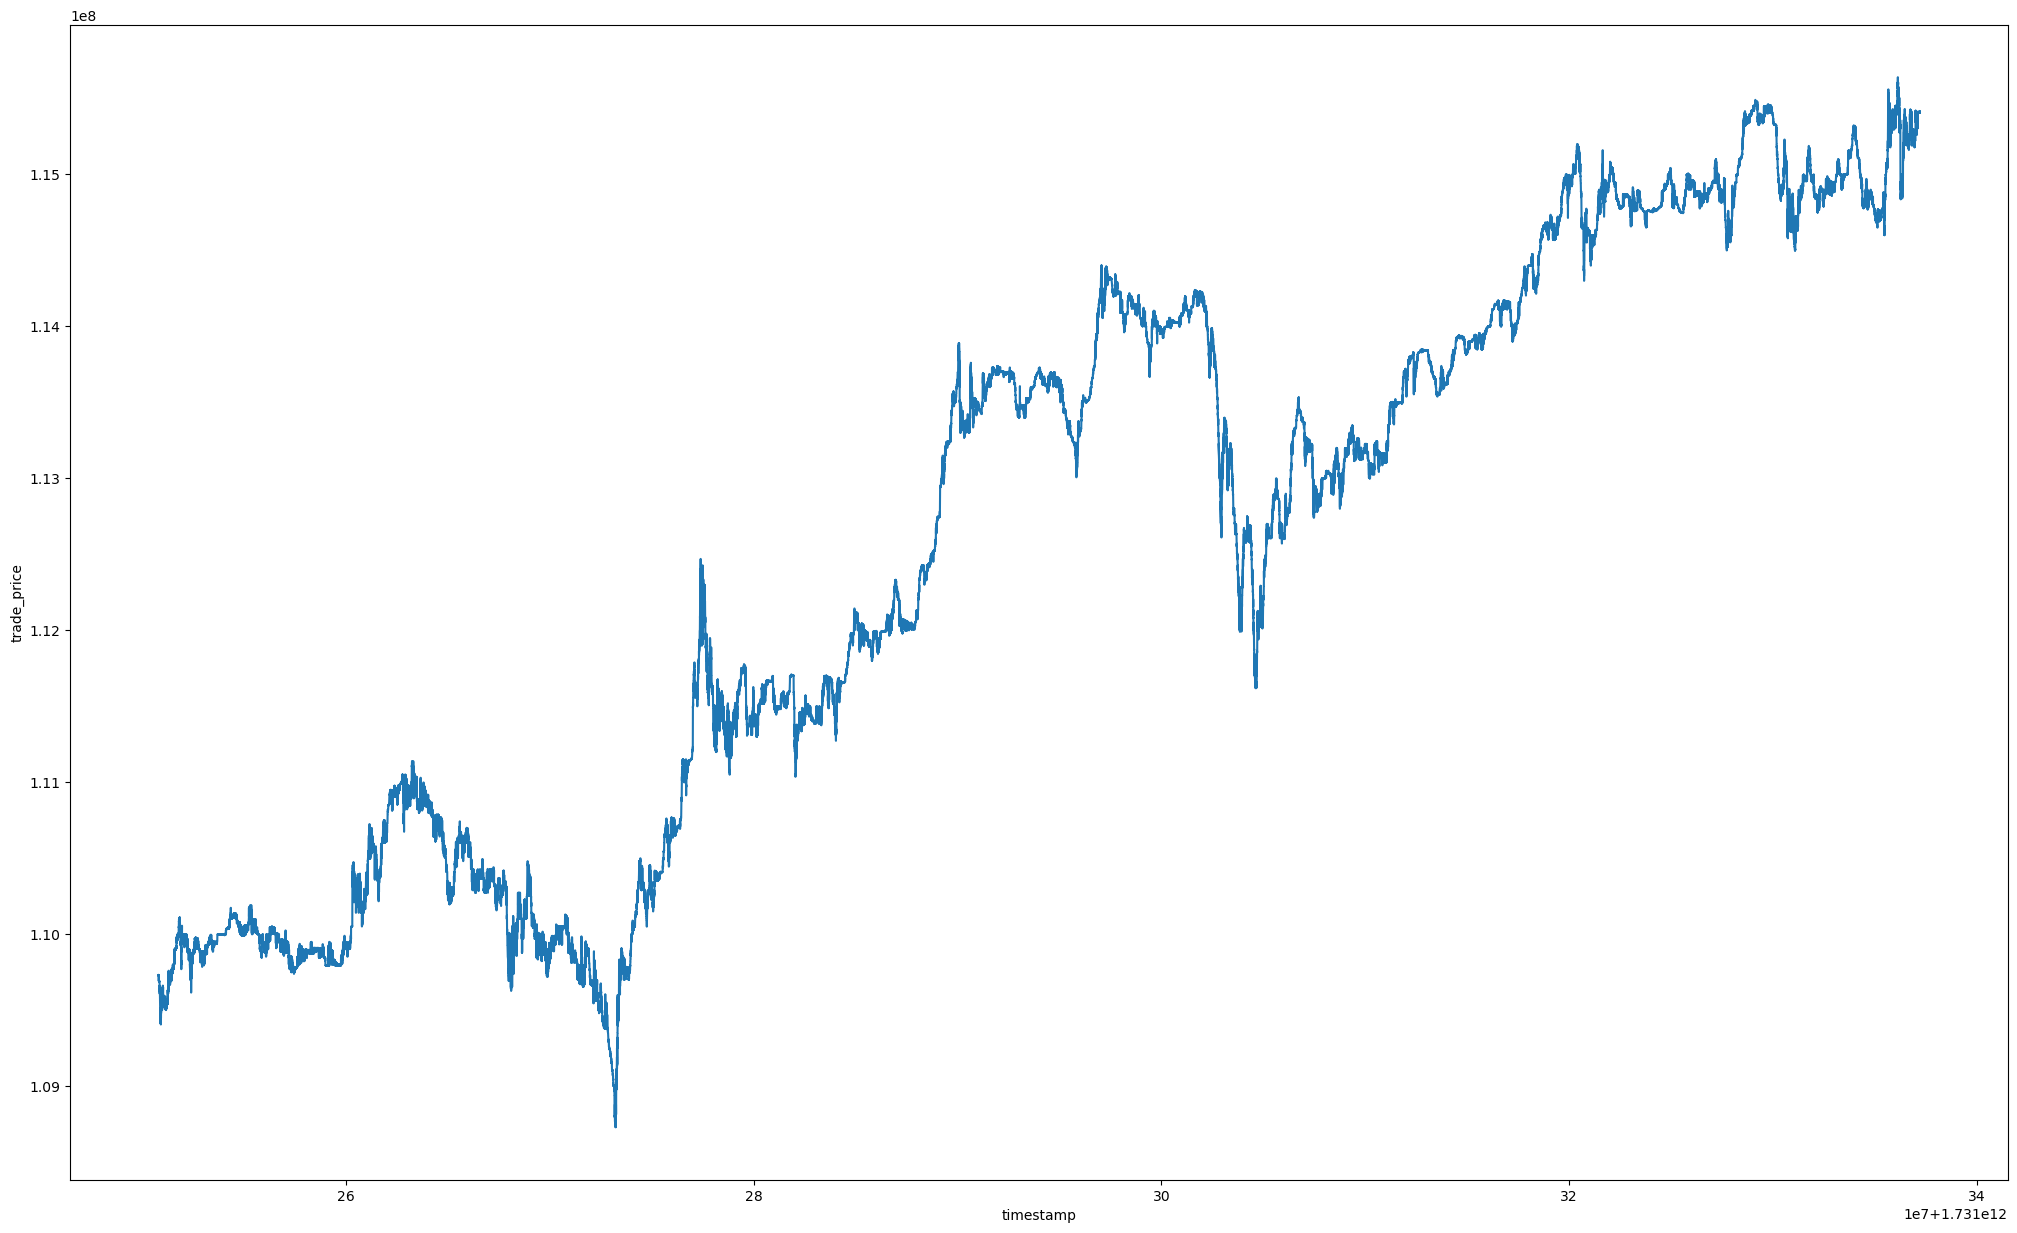

In [42]:
plt.figure(figsize=(25,15))
sns.lineplot(df1, x="timestamp", y="trade_price")

# (3) 전처리2: 모델링을 위한 추가 전처리

## (3-1) 데이터 불러오기

In [3]:
#현재 작업 디렉토리 확인
os.getcwd()

'C:\\Users\\lys17\\Desktop\\InduStat\\code'

In [5]:
#시작 시간 기록
start_time = time.time()

#폴더 경로 및 파일 패턴 설정
folder_path = "..\\data\\preprocessed"  #preprocessed 폴더 경로
file_pattern = os.path.join(folder_path, '*.csv')  #preprocessed 폴더 내 모든 CSV 파일의 패턴

#모든 CSV 파일을 리스트로 불러오기
file_list = glob.glob(file_pattern) #모든 csv파일의 경로를 문자열로 저장

#각 파일을 읽어서 데이터프레임 리스트에 저장 (로딩 바 추가)
df_list = []
for file in tqdm(file_list, desc="Loading CSV files"):
    df = pd.read_csv(file)
    df_list.append(df)

#데이터프레임을 하나로 합치기
combined_df = pd.concat(df_list, ignore_index=True)

#총 걸린 시간 계산 및 출력
end_time = time.time()
print(f"\nTotal time taken: {end_time - start_time:.2f} seconds")

Loading CSV files: 100%|███████████████████████████████████████████████████████████████| 50/50 [01:37<00:00,  1.95s/it]



Total time taken: 103.08 seconds


In [6]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8540797 entries, 0 to 8540796
Data columns (total 33 columns):
 #   Column           Dtype  
---  ------           -----  
 0   timestamp        int64  
 1   total_ask_size   float64
 2   total_bid_size   float64
 3   1_ask_price      float64
 4   1_ask_size       float64
 5   1_bid_price      float64
 6   1_bid_size       float64
 7   2_ask_price      float64
 8   2_ask_size       float64
 9   2_bid_price      float64
 10  2_bid_size       float64
 11  3_ask_price      float64
 12  3_ask_size       float64
 13  3_bid_price      float64
 14  3_bid_size       float64
 15  4_ask_price      float64
 16  4_ask_size       float64
 17  4_bid_price      float64
 18  4_bid_size       float64
 19  5_ask_price      float64
 20  5_ask_size       float64
 21  5_bid_price      float64
 22  5_bid_size       float64
 23  trade_price      float64
 24  trade_volume     float64
 25  ask_bid          object 
 26  spread           float64
 27  imbalance   

## (3-2) 변수 선택

<Axes: >

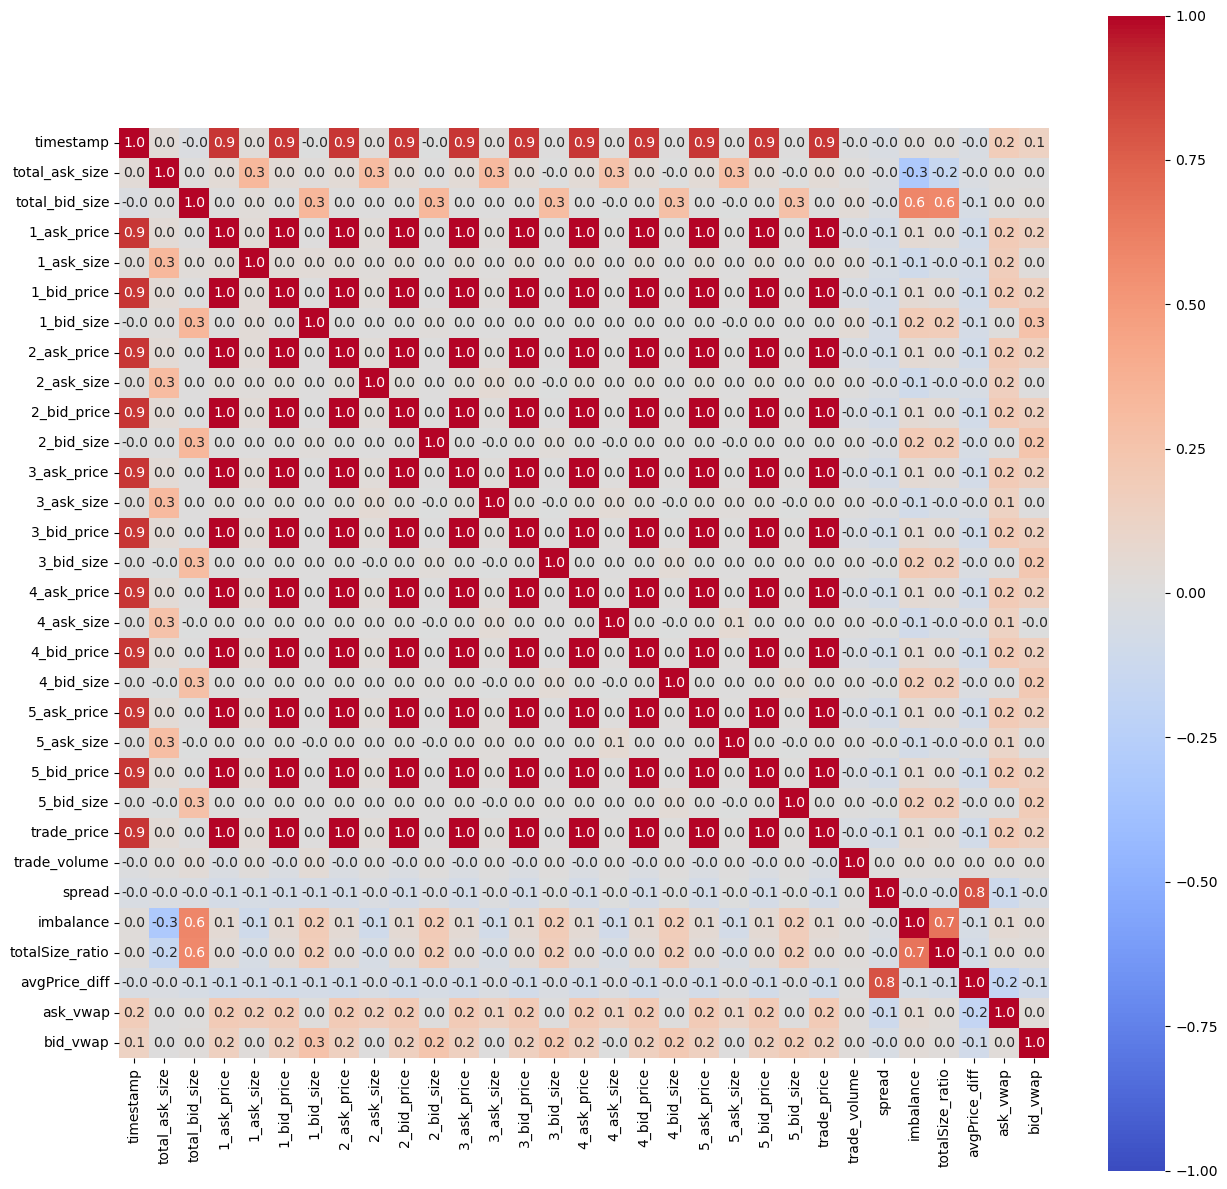

In [8]:
#상관계수 계산
corr_matrix = combined_df.drop(['ask_bid', 'cum_vp'], axis=1).corr() #ask_bid는 범주형이므로 제외, cum_vp는 초반에 inf값이 있으므로 제외

#heatmap 생성
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, center=0, annot=True, square=True, fmt=".1f")
#vmin=-1 / vmax=1 / center=0: 0을 기준으로 음수는 파란색, 양수는 빨간색 계열로 표시

**Heatmap 해석**
1. (timestamp, i_ask_price), (timestamp, i_bid_price), (timestamp, trade_price), (timestamp, ask_vwap), (timestamp, bid_vwap)의 상관계수는 약 0.9 이다.
   - 시간이 지남에 따라 1~5 매도호가와 매수호가, 체결가, 거래량가중평균가는 유사한 방향으로 움직이는 경향이 강하다.
   - 즉, 시간이 흐르면서 모두 양의 방향으로 움직이는 경향을 보인다.
2. i_ask_price, i_bid_price, trade_price, ask_vwap, bid_vwap는 서로의 상관계수가 약 1.0이다.
   - 이들 중 하나만 선택해도 모델 학습에 무관할 것 같다.
   - 하나만 선택하게 된다면, y(타겟변수)가 될 trade_price를 선택해야 한다.
3. (spread, avgPrice_diff)는 상관계수가 약 0.8이다.
   - 둘 중 하나만 선택해도 모델 학습에 무관할 것 같다.
   - 두 파생변수는 의미가 비슷하므로 spread만 선택해도 될 것 같다.

**결론**
1. i_ask_price, i_bid_price, trade_price, ask_vwap, bid_vwap 중 trade_price만 선택한다.
2. spread와 avgPrice_dff 중에선 spread만 선택한다.
3. (임시) ask_bid는 모델 학습에 큰 영향을 줄 것 같지 않아서 제외한다.
4. (임시) cum_vp는 초반에 inf값 처리 문제로 일단 제외한다.

In [11]:
#위 결론에 따라 불필요한 열 제거
combined_df.drop([f'{i}_ask_price' for i in range(1,6)] + [f'{i}_bid_price' for i in range(1,6)] + ["ask_vwap", "bid_vwap", "avgPrice_diff", "ask_bid", "cum_vp"], axis = 1, inplace = True)

In [12]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8540797 entries, 0 to 8540796
Data columns (total 18 columns):
 #   Column           Dtype  
---  ------           -----  
 0   timestamp        int64  
 1   total_ask_size   float64
 2   total_bid_size   float64
 3   1_ask_size       float64
 4   1_bid_size       float64
 5   2_ask_size       float64
 6   2_bid_size       float64
 7   3_ask_size       float64
 8   3_bid_size       float64
 9   4_ask_size       float64
 10  4_bid_size       float64
 11  5_ask_size       float64
 12  5_bid_size       float64
 13  trade_price      float64
 14  trade_volume     float64
 15  spread           float64
 16  imbalance        float64
 17  totalSize_ratio  float64
dtypes: float64(17), int64(1)
memory usage: 1.1 GB


## (3-3) 종속변수 y 생성

In [14]:
#combined_df를 timestamp 기준으로 정렬
combined_df = combined_df.sort_values('timestamp')

#10분 후의 timestamp를 계산하여 새 열 생성
combined_df['timestamp_10min_later'] = combined_df['timestamp'] + 600000 #10분 후 = +600,000

#원본 데이터프레임과 10분 후 timestamp 기준으로 가장 가까운 행을 병합
df_merged = pd.merge_asof(combined_df,
                          combined_df[['timestamp', 'trade_price']].rename(columns={'timestamp': 'nearest_timestamp', 'trade_price': 'nearest_trade_price'}),
                          left_on='timestamp_10min_later',
                          right_on='nearest_timestamp',
                          direction='forward') #10분 후 시점에 가장 가까운 다음 timestamp를 기준으로 병합 진행 (모델 run time 기준이 10분이니까 최소 10분은 지나야함)

#trade_price 비교하여 trade_price_10min_later 열 생성
df_merged['trade_price_10min_later'] = (df_merged['nearest_trade_price'] > df_merged['trade_price']).astype(int) #현재가(trade_price)보다 높으면 1, 아니면 0
df_merged

,timestamp,total_ask_size,total_bid_size,1_ask_size,1_bid_size,2_ask_size,2_bid_size,3_ask_size,3_bid_size,4_ask_size,4_bid_size,5_ask_size,5_bid_size,trade_price,trade_volume,spread,imbalance,totalSize_ratio,timestamp_10min_later,nearest_timestamp,nearest_trade_price,trade_price_10min_later
0,1727017200386,0.499237,0.925602,0.032215,0.005979,0.006364,0.016141,0.122240,0.063830,0.000120,0.300359,0.001020,0.080266,83658000.0,0.000100,36000.0,0.299237,1.854033,1727017800386,1.727018e+12,83682000.0,1
1,1727017201586,0.501627,0.896695,0.032215,0.005979,0.006364,0.016141,0.122240,0.300359,0.000120,0.080266,0.001020,0.142020,83658000.0,0.000100,36000.0,0.282530,1.787573,1727017801586,1.727018e+12,83682000.0,1
2,1727017201786,0.501627,0.861926,0.032215,0.000061,0.006364,0.005979,0.122240,0.016141,0.000120,0.300359,0.001020,0.080266,83658000.0,0.000100,33000.0,0.264235,1.718261,1727017801786,1.727018e+12,83682000.0,1
3,1727017202086,0.500431,0.861926,0.031019,0.000061,0.006364,0.005979,0.122240,0.016141,0.000120,0.300359,0.001020,0.080266,83658000.0,0.001195,33000.0,0.265345,1.722365,1727017802086,1.727018e+12,83682000.0,1
4,1727017202486,0.500431,0.878067,0.031019,0.000061,0.006364,0.005979,0.122240,0.032282,0.000120,0.300359,0.001020,0.080266,83658000.0,0.001195,33000.0,0.273947,1.754620,1727017802486,1.727018e+12,83682000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8540792,1731337199013,1.688894,1.251400,0.012794,0.003277,0.032234,0.000094,0.600973,0.066562,0.291058,0.610536,0.000916,0.010109,115415000.0,0.000043,1000.0,-0.148793,0.740958,1731337799013,NaN,NaN,0
8540793,1731337199213,1.688894,1.251400,0.012794,0.003277,0.032234,0.000094,0.600973,0.066562,0.291058,0.610536,0.000916,0.010109,115415000.0,0.000043,1000.0,-0.148793,0.740958,1731337799213,NaN,NaN,0
8540794,1731337199413,1.688851,1.251400,0.012751,0.003277,0.032234,0.000094,0.600973,0.066562,0.291058,0.610536,0.000916,0.010109,115415000.0,0.000043,1000.0,-0.148780,0.740977,1731337799413,NaN,NaN,0
8540795,1731337199813,1.688851,1.297972,0.012751,0.062367,0.032234,0.610536,0.600973,0.010109,0.291058,0.006261,0.000916,0.461350,115405000.0,0.004195,10000.0,-0.130868,0.768554,1731337799813,NaN,NaN,0


In [15]:
#nearest_timestamp가 NaN인 경우는 제거
df_merged = df_merged.dropna().reset_index(drop=True)
df_merged

,timestamp,total_ask_size,total_bid_size,1_ask_size,1_bid_size,2_ask_size,2_bid_size,3_ask_size,3_bid_size,4_ask_size,4_bid_size,5_ask_size,5_bid_size,trade_price,trade_volume,spread,imbalance,totalSize_ratio,timestamp_10min_later,nearest_timestamp,nearest_trade_price,trade_price_10min_later
0,1727017200386,0.499237,0.925602,0.032215,0.005979,0.006364,0.016141,0.12224,0.063830,0.000120,0.300359,0.00102,0.080266,83658000.0,0.000100,36000.0,0.299237,1.854033,1727017800386,1.727018e+12,83682000.0,1
1,1727017201586,0.501627,0.896695,0.032215,0.005979,0.006364,0.016141,0.12224,0.300359,0.000120,0.080266,0.00102,0.142020,83658000.0,0.000100,36000.0,0.282530,1.787573,1727017801586,1.727018e+12,83682000.0,1
2,1727017201786,0.501627,0.861926,0.032215,0.000061,0.006364,0.005979,0.12224,0.016141,0.000120,0.300359,0.00102,0.080266,83658000.0,0.000100,33000.0,0.264235,1.718261,1727017801786,1.727018e+12,83682000.0,1
3,1727017202086,0.500431,0.861926,0.031019,0.000061,0.006364,0.005979,0.12224,0.016141,0.000120,0.300359,0.00102,0.080266,83658000.0,0.001195,33000.0,0.265345,1.722365,1727017802086,1.727018e+12,83682000.0,1
4,1727017202486,0.500431,0.878067,0.031019,0.000061,0.006364,0.005979,0.12224,0.032282,0.000120,0.300359,0.00102,0.080266,83658000.0,0.001195,33000.0,0.273947,1.754620,1727017802486,1.727018e+12,83682000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8539356,1731336597993,0.964932,0.630721,0.020055,0.009224,0.020583,0.205333,0.10297,0.100730,0.131715,0.003442,0.04228,0.000434,115201000.0,0.000886,61000.0,-0.209451,0.653643,1731337197993,1.731337e+12,115414000.0,1
8539357,1731336598093,0.964932,0.630721,0.020055,0.009224,0.020583,0.205333,0.10297,0.100730,0.131715,0.003442,0.04228,0.000434,115201000.0,0.000886,61000.0,-0.209451,0.653643,1731337198093,1.731337e+12,115414000.0,1
8539358,1731336598593,0.964932,0.634150,0.020055,0.004341,0.020583,0.009224,0.10297,0.205333,0.131715,0.100730,0.04228,0.003442,115201000.0,0.000886,60000.0,-0.206858,0.657196,1731337198593,1.731337e+12,115414000.0,1
8539359,1731336599093,0.963627,0.588224,0.018750,0.004441,0.020583,0.009224,0.10297,0.205333,0.131715,0.100730,0.04228,0.003442,115262000.0,0.000652,60000.0,-0.241907,0.610427,1731337199093,1.731337e+12,115415000.0,1


In [16]:
#불필요한 열 제거
df_merged.drop(['timestamp_10min_later', 'nearest_timestamp', 'nearest_trade_price'], axis=1, inplace=True)

In [17]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8539361 entries, 0 to 8539360
Data columns (total 19 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   timestamp                int64  
 1   total_ask_size           float64
 2   total_bid_size           float64
 3   1_ask_size               float64
 4   1_bid_size               float64
 5   2_ask_size               float64
 6   2_bid_size               float64
 7   3_ask_size               float64
 8   3_bid_size               float64
 9   4_ask_size               float64
 10  4_bid_size               float64
 11  5_ask_size               float64
 12  5_bid_size               float64
 13  trade_price              float64
 14  trade_volume             float64
 15  spread                   float64
 16  imbalance                float64
 17  totalSize_ratio          float64
 18  trade_price_10min_later  int32  
dtypes: float64(17), int32(1), int64(1)
memory usage: 1.2 GB


# (4) timestamp 초 단위로 통일

In [27]:
#timestamp를 초 단위로 계산 (1초 = 1000)
df_merged["timestamp"] = df_merged["timestamp"] // 1000
df_merged

,timestamp,total_ask_size,total_bid_size,1_ask_size,1_bid_size,2_ask_size,2_bid_size,3_ask_size,3_bid_size,4_ask_size,4_bid_size,5_ask_size,5_bid_size,trade_price,trade_volume,spread,imbalance,totalSize_ratio,trade_price_10min_later
0,1727017200,0.499237,0.925602,0.032215,0.005979,0.006364,0.016141,0.12224,0.063830,0.000120,0.300359,0.00102,0.080266,83658000.0,0.000100,36000.0,0.299237,1.854033,1
1,1727017201,0.501627,0.896695,0.032215,0.005979,0.006364,0.016141,0.12224,0.300359,0.000120,0.080266,0.00102,0.142020,83658000.0,0.000100,36000.0,0.282530,1.787573,1
2,1727017201,0.501627,0.861926,0.032215,0.000061,0.006364,0.005979,0.12224,0.016141,0.000120,0.300359,0.00102,0.080266,83658000.0,0.000100,33000.0,0.264235,1.718261,1
3,1727017202,0.500431,0.861926,0.031019,0.000061,0.006364,0.005979,0.12224,0.016141,0.000120,0.300359,0.00102,0.080266,83658000.0,0.001195,33000.0,0.265345,1.722365,1
4,1727017202,0.500431,0.878067,0.031019,0.000061,0.006364,0.005979,0.12224,0.032282,0.000120,0.300359,0.00102,0.080266,83658000.0,0.001195,33000.0,0.273947,1.754620,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8539356,1731336597,0.964932,0.630721,0.020055,0.009224,0.020583,0.205333,0.10297,0.100730,0.131715,0.003442,0.04228,0.000434,115201000.0,0.000886,61000.0,-0.209451,0.653643,1
8539357,1731336598,0.964932,0.630721,0.020055,0.009224,0.020583,0.205333,0.10297,0.100730,0.131715,0.003442,0.04228,0.000434,115201000.0,0.000886,61000.0,-0.209451,0.653643,1
8539358,1731336598,0.964932,0.634150,0.020055,0.004341,0.020583,0.009224,0.10297,0.205333,0.131715,0.100730,0.04228,0.003442,115201000.0,0.000886,60000.0,-0.206858,0.657196,1
8539359,1731336599,0.963627,0.588224,0.018750,0.004441,0.020583,0.009224,0.10297,0.205333,0.131715,0.100730,0.04228,0.003442,115262000.0,0.000652,60000.0,-0.241907,0.610427,1


In [31]:
#동일한 timestamp는 첫 번째 경우만 남겨두고 제거 (1초 단위에 한 행만 존재해야 하니까)
df_merged = df_merged.drop_duplicates(subset="timestamp")
df_merged

,timestamp,total_ask_size,total_bid_size,1_ask_size,1_bid_size,2_ask_size,2_bid_size,3_ask_size,3_bid_size,4_ask_size,4_bid_size,5_ask_size,5_bid_size,trade_price,trade_volume,spread,imbalance,totalSize_ratio,trade_price_10min_later
0,1727017200,0.499237,0.925602,0.032215,0.005979,0.006364,0.016141,0.122240,0.063830,0.000120,0.300359,0.00102,0.080266,83658000.0,0.000100,36000.0,0.299237,1.854033,1
1,1727017201,0.501627,0.896695,0.032215,0.005979,0.006364,0.016141,0.122240,0.300359,0.000120,0.080266,0.00102,0.142020,83658000.0,0.000100,36000.0,0.282530,1.787573,1
3,1727017202,0.500431,0.861926,0.031019,0.000061,0.006364,0.005979,0.122240,0.016141,0.000120,0.300359,0.00102,0.080266,83658000.0,0.001195,33000.0,0.265345,1.722365,1
6,1727017203,0.500431,0.878067,0.031019,0.000061,0.006364,0.005979,0.122240,0.032282,0.000120,0.300359,0.00102,0.080266,83658000.0,0.001195,33000.0,0.273947,1.754620,1
8,1727017204,0.498579,0.878067,0.029166,0.000061,0.006364,0.005979,0.122240,0.032282,0.000120,0.300359,0.00102,0.080266,83658000.0,0.000598,33000.0,0.275661,1.761140,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8539350,1731336595,0.976525,0.569786,0.035665,0.003657,0.020583,0.204899,0.098953,0.094487,0.131715,0.003442,0.04228,0.000434,115262000.0,0.001371,61000.0,-0.263038,0.583484,1
8539352,1731336596,0.978723,0.652087,0.035665,0.085957,0.020583,0.204899,0.101152,0.094487,0.131715,0.003442,0.04228,0.000434,115262000.0,0.001371,61000.0,-0.200291,0.666263,1
8539354,1731336597,0.973544,0.576239,0.028727,0.010109,0.020583,0.204899,0.102910,0.094487,0.131715,0.003442,0.04228,0.000434,115201000.0,0.072191,61000.0,-0.256362,0.591898,1
8539357,1731336598,0.964932,0.630721,0.020055,0.009224,0.020583,0.205333,0.102970,0.100730,0.131715,0.003442,0.04228,0.000434,115201000.0,0.000886,61000.0,-0.209451,0.653643,1


In [35]:
#index 재정렬
df_merged = df_merged.reset_index(drop=True)
df_merged

,timestamp,total_ask_size,total_bid_size,1_ask_size,1_bid_size,2_ask_size,2_bid_size,3_ask_size,3_bid_size,4_ask_size,4_bid_size,5_ask_size,5_bid_size,trade_price,trade_volume,spread,imbalance,totalSize_ratio,trade_price_10min_later
0,1727017200,0.499237,0.925602,0.032215,0.005979,0.006364,0.016141,0.122240,0.063830,0.000120,0.300359,0.00102,0.080266,83658000.0,0.000100,36000.0,0.299237,1.854033,1
1,1727017201,0.501627,0.896695,0.032215,0.005979,0.006364,0.016141,0.122240,0.300359,0.000120,0.080266,0.00102,0.142020,83658000.0,0.000100,36000.0,0.282530,1.787573,1
2,1727017202,0.500431,0.861926,0.031019,0.000061,0.006364,0.005979,0.122240,0.016141,0.000120,0.300359,0.00102,0.080266,83658000.0,0.001195,33000.0,0.265345,1.722365,1
3,1727017203,0.500431,0.878067,0.031019,0.000061,0.006364,0.005979,0.122240,0.032282,0.000120,0.300359,0.00102,0.080266,83658000.0,0.001195,33000.0,0.273947,1.754620,1
4,1727017204,0.498579,0.878067,0.029166,0.000061,0.006364,0.005979,0.122240,0.032282,0.000120,0.300359,0.00102,0.080266,83658000.0,0.000598,33000.0,0.275661,1.761140,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944144,1731336595,0.976525,0.569786,0.035665,0.003657,0.020583,0.204899,0.098953,0.094487,0.131715,0.003442,0.04228,0.000434,115262000.0,0.001371,61000.0,-0.263038,0.583484,1
3944145,1731336596,0.978723,0.652087,0.035665,0.085957,0.020583,0.204899,0.101152,0.094487,0.131715,0.003442,0.04228,0.000434,115262000.0,0.001371,61000.0,-0.200291,0.666263,1
3944146,1731336597,0.973544,0.576239,0.028727,0.010109,0.020583,0.204899,0.102910,0.094487,0.131715,0.003442,0.04228,0.000434,115201000.0,0.072191,61000.0,-0.256362,0.591898,1
3944147,1731336598,0.964932,0.630721,0.020055,0.009224,0.020583,0.205333,0.102970,0.100730,0.131715,0.003442,0.04228,0.000434,115201000.0,0.000886,61000.0,-0.209451,0.653643,1


# (5) 데이터를 csv파일로 저장

In [37]:
#모델링 전 최종 데이터프레임을 csv파일로 저장
df_merged.to_csv("../data/final_data.csv", index=False)